<center>
    <h1>Identifying the Human Values behind Arguments</h1>
    <h1>05 - Error Analysis</h1>
    <h2>Natural Language Processing</h2>
    <h3>Antonio Politano, Enrico Pittini, Riccardo Spolaor and Samuele Bortolato</h3>
    <h4>antonio.politano2@studio.unibo.it, enrico.pittini@studio.unibo.it, riccardo.spolaor@studio.unibo.it, samuele.bortolato@studio.unibo.it</h4>
</center>

---

In this notebook error analysis is performed on the *Main Model*.

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `src` folder.

In [1]:
# Settings for autoreloading.

%load_ext autoreload
%autoreload 2

In [2]:
# Settings for reproducibility.

from src.utils.seeder import set_random_seed

SEED = 42
set_random_seed(SEED)

c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download of the Dataset

In [3]:
from src.datasets.dataset_builder import get_dataframes

arguments_test_df, labels_test_df = get_dataframes('data', 'validation')

In [4]:
TARGETS = labels_test_df.columns.to_list()

# Model and Tokenizer Definition

In [5]:
from torch import cuda
from transformers import logging

MODEL_NAME = 'bert-base-uncased'
DEVICE = 'cuda' if cuda.is_available() else 'cpu'

# Set verbosity at "error" level
logging.set_verbosity_error()

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, problem_type='multi_label_classification')

# Add the tokens encoding the stance to the tokenizer.
tokenizer.add_tokens(['[FAV]', '[AGN]'], special_tokens=True)

# Build a dictionary to encde the stance.
stance_encoder = {'in favor of': '[FAV]', 'against': '[AGN]'}

In [7]:
from src.models.transformer_model import get_transformer_model

model = get_transformer_model(MODEL_NAME, num_labels=len(TARGETS),
                              tokenizer=tokenizer, device=DEVICE)

In [8]:
print('Model structure:')
print(model)

Model structure:
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30524, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [9]:
import os
import torch

# Get the best model checkpoints.
checkpoint = torch.load(os.path.join('models', 'main_model.pth'))

# Load the best model weights.
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Error Analysis on the Test Set

In [10]:
from src.datasets.dataloader_builder import get_dataloader

BATCH_SIZE_EVAL = 16

test_loader = get_dataloader(arguments_test_df, labels_test_df, tokenizer,
                             stance_encoder, batch_size=BATCH_SIZE_EVAL,
                             shuffle=False, use_augmentation=False)

In [11]:
import numpy as np
import os
from src.evaluation.evaluation import get_dataset_predictions

thresholds_per_target = np.load(
    os.path.join('models', 'main_model_thresholds.npy'))

y_preds, y_true = get_dataset_predictions(model, test_loader, DEVICE,
                                          thresholds_per_target)

In [12]:
from src.evaluation.error_analysis import get_k_worst_predicted_instances

worst_predicted_instances, worst_predicted_instances_targets = \
    get_k_worst_predicted_instances(arguments_test_df, labels_test_df,
    y_true, y_preds, n_worst_instances=50)

In [13]:
worst_predicted_instances.head()

,Conclusion,Stance,Premise,Labels
759,We should abandon television,against,television provides entertainment and news for...,"[Self-direction: thought, Stimulation, Hedonis..."
19,The vow of celibacy should be abandoned,in favor of,there is a serious shortage of priests and thi...,"[Self-direction: thought, Self-direction: acti..."
366,The vow of celibacy should be abandoned,in favor of,"i consider it a sensitive issue, however, beca...","[Self-direction: action, Stimulation, Hedonism..."
952,We should subsidize vocational education,against,Subsidies should be given only if they lead to...,"[Self-direction: action, Security: societal, B..."
1010,We should abandon television,in favor of,television is a medium that no longer provides...,"[Achievement, Conformity: rules, Humility]"


In [14]:
worst_predicted_instances_targets.head()

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
759,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
19,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1
366,0,1,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0
952,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1010,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


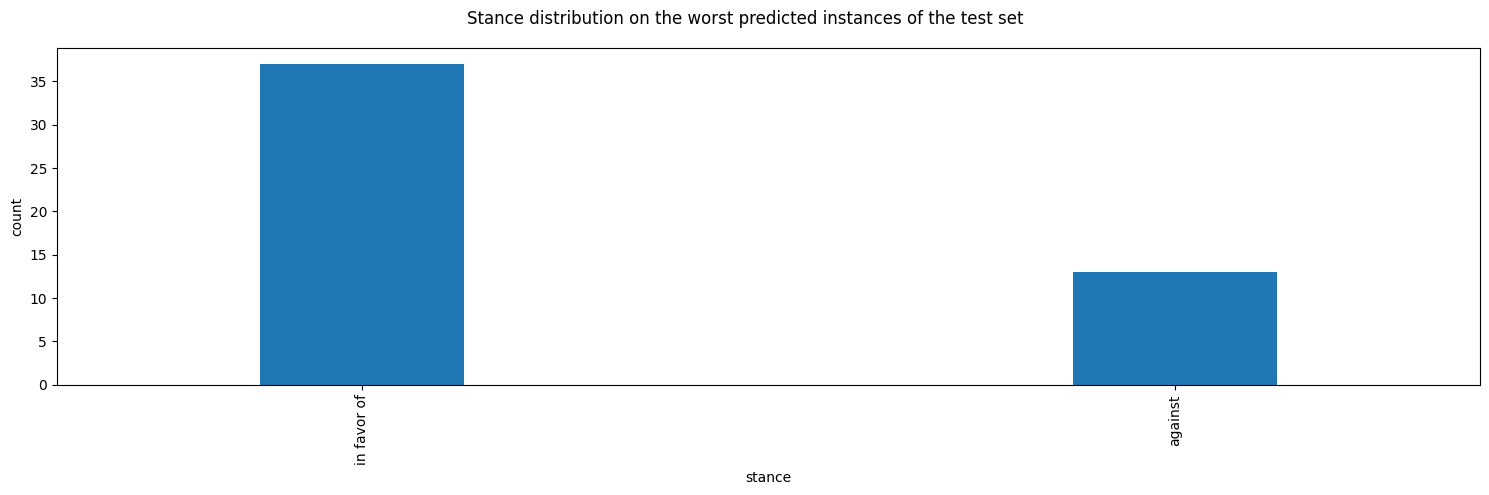

In [15]:
from src.datasets.dataset_analysis import plot_stance_distribution

plot_stance_distribution(worst_predicted_instances,
                         title='Stance distribution on the worst predicted instances of the test set')

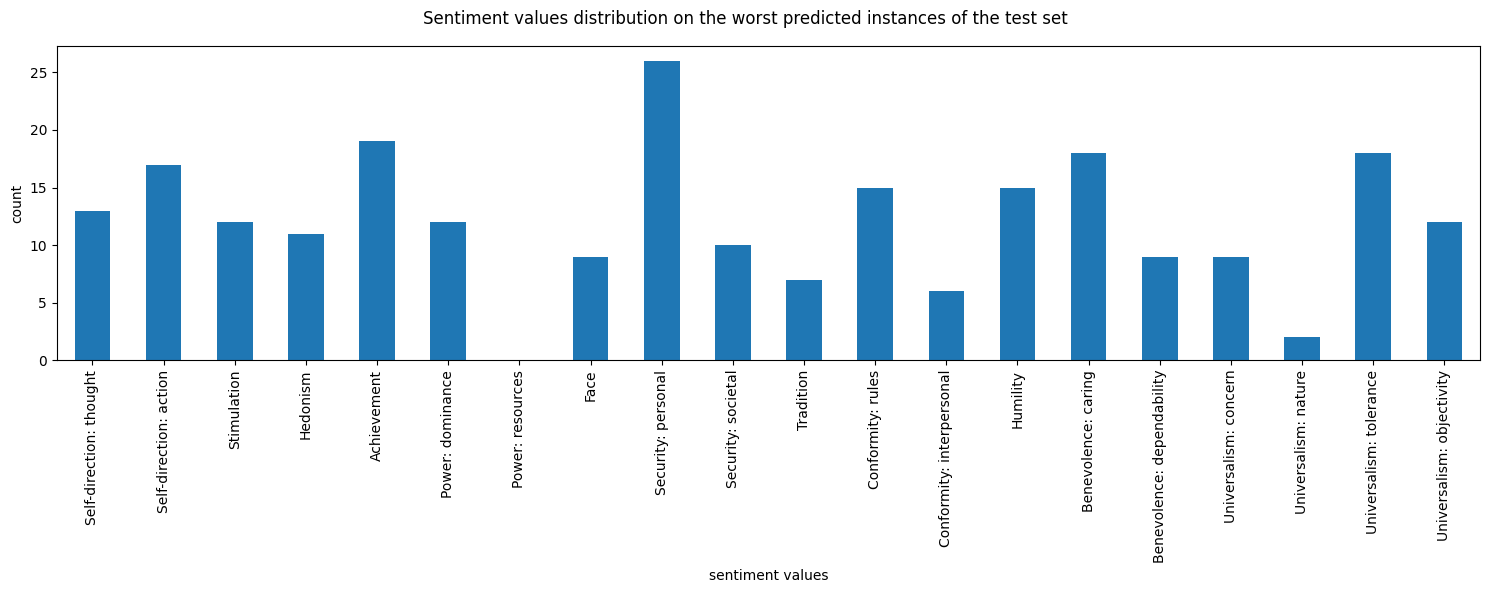

In [16]:
from src.datasets.dataset_analysis import plot_sentiment_distribution

plot_sentiment_distribution(worst_predicted_instances_targets,
                            title='Sentiment values distribution on the worst predicted instances of the test set')

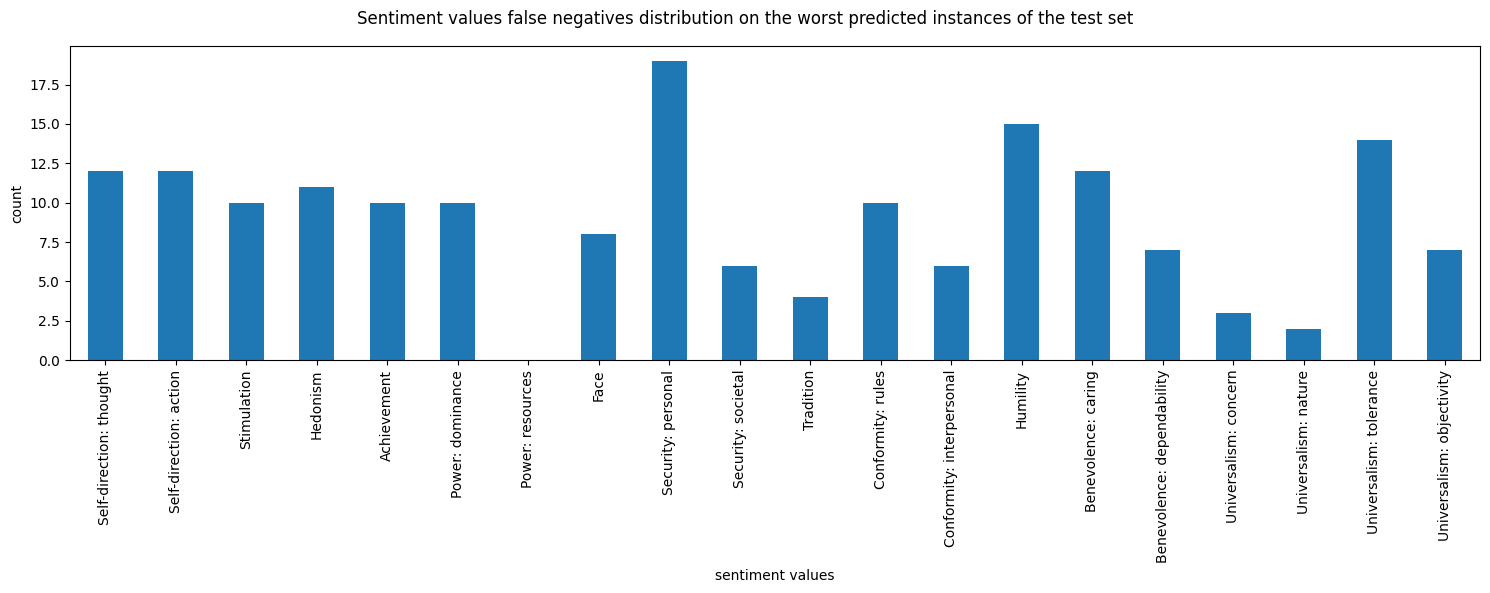

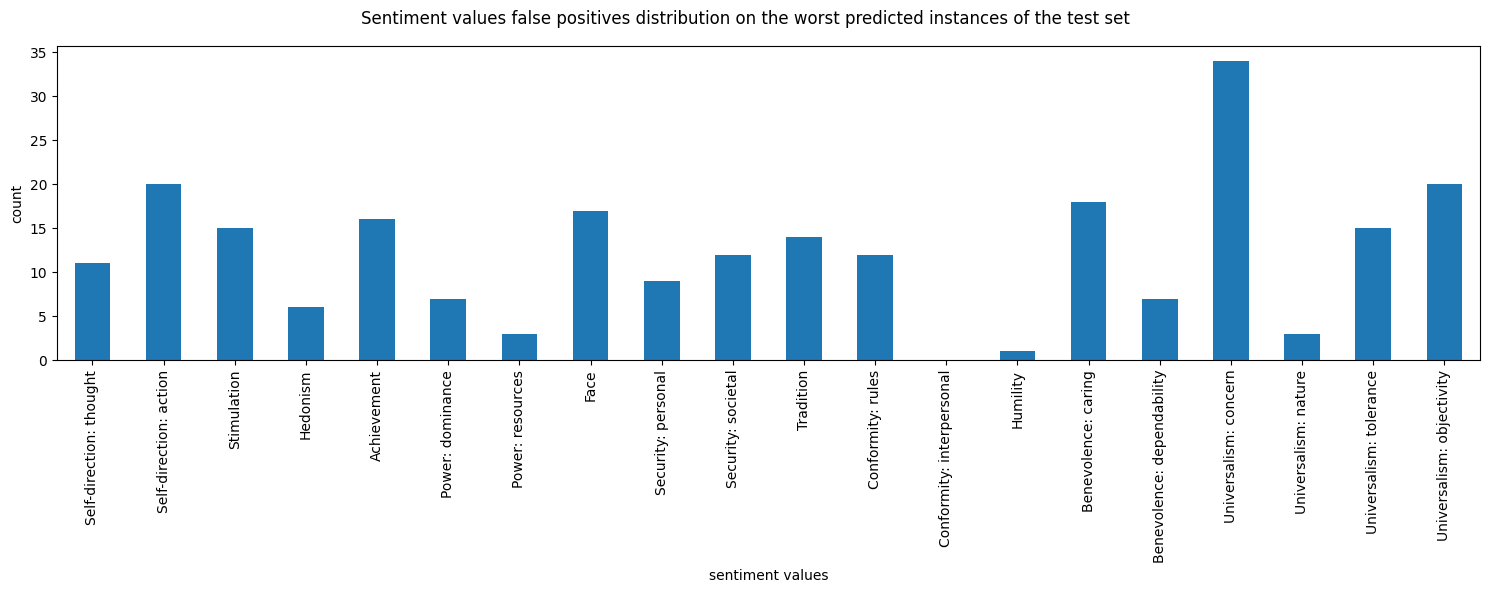

In [17]:
from src.evaluation.error_analysis import \
    plot_sentiment_values_false_negatives_and_positives

plot_sentiment_values_false_negatives_and_positives(
    worst_predicted_instances_targets, y_true, y_preds, TARGETS)

In [18]:
from src.evaluation.error_analysis import print_k_worst_predicted_instances

print_k_worst_predicted_instances(worst_predicted_instances, y_true, y_preds,
                                  TARGETS, n_worst_instances=5)

Worst instance 1:
-----------------
Premise: "television provides entertainment and news for all generations"
Stance: "against"
Conclusion: "We should abandon television"
True targets: "Self-direction: thought; Stimulation; Hedonism; Universalism: tolerance; Universalism: objectivity"
Predicted targets: "Achievement; Power: dominance; Face; Security: personal; Security: societal; Benevolence: caring; Universalism: concern; Universalism: objectivity"

Worst instance 2:
-----------------
Premise: "there is a serious shortage of priests and this can be remedied by abandoning the vow of celibacy."
Stance: "in favor of"
Conclusion: "The vow of celibacy should be abandoned"
True targets: "Self-direction: thought; Self-direction: action; Power: dominance; Benevolence: dependability; Universalism: tolerance; Universalism: objectivity"
Predicted targets: "Security: personal; Security: societal; Tradition; Universalism: concern"

Worst instance 3:
-----------------
Premise: "i consider it a sens